## Setup

In [30]:
import os
import torch
import pandas as pd
from torch import nn
from torch.autograd import Variable

In [31]:
# Использовать gpu
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [32]:
!pip install transformers
!apt-get install unzip wget -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
wget is already the newest version (1.19.4-1ubuntu2.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [33]:
PATH_TO_DISK = '/content/drive'

In [34]:
from google.colab import drive
drive.mount(PATH_TO_DISK)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download pretrained model and pretrained tokenizer

In [35]:
PATH_TO_MODEL = 'sberbank-ai/sbert_large_nlu_ru'

PATH_TO_PRETRAINED_TOKENIZER = 'sberbank-ai/sbert_large_nlu_ru'

In [36]:
# Загрузить sbertTokenizer
from transformers import AutoTokenizer, AutoModel

sbertTokenizer = AutoTokenizer.from_pretrained(PATH_TO_PRETRAINED_TOKENIZER)

In [37]:
# Загружаем модель.
model = AutoModel.from_pretrained(PATH_TO_MODEL)

# Переносим модель на GPU
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(120138, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fal

In [38]:
# Проверим, что модель правильно загрузилась
tokenized_sent = sbertTokenizer(['Инфляция - жуткая штука'], padding=True, truncation=True, max_length=20)
inds = torch.tensor(tokenized_sent['input_ids'])
attention_mask = torch.tensor(tokenized_sent['attention_mask'])
inds_cuda = inds.to(device)
attention_mask_cuda = attention_mask.to(device)
model.eval()
model(inds_cuda, attention_mask=attention_mask_cuda)

BaseModelOutputWithPoolingAndCrossAttentions([('last_hidden_state',
                                               tensor([[[-0.1171, -0.5547,  0.3396,  ...,  0.5373, -0.9762,  1.4210],
                                                        [ 0.6806,  0.0290,  0.6023,  ...,  0.1934, -0.6857,  1.0496],
                                                        [ 0.1594, -0.4141,  0.4344,  ..., -0.2450, -0.4732,  1.2877],
                                                        [-0.0997, -0.5750,  0.5007,  ...,  0.3665, -0.1641,  1.0917],
                                                        [-0.1514, -0.4705,  0.4593,  ...,  0.2352, -0.4895,  1.0387],
                                                        [-0.3243, -0.2609, -0.6128,  ..., -0.1549, -0.9934,  0.6505]]],
                                                      device='cuda:0', grad_fn=<NativeLayerNormBackward>)),
                                              ('pooler_output',
                                               ten

# Prepare data


In [39]:
# Путь к файлу с данными в .csv формате.
# Здесь мы используем датасет Lenta.ru
PATH_TO_DATA = os.path.join(PATH_TO_DISK, 'My Drive', 'Colab Notebooks/test-lenta.csv')

# Если данные в .zip файле, предварительно их нужно распаковать и указать путь на распакованный .csv-файл
# !unzip -o PATH_TO_DATA
# PATH_TO_DATA = ...

TOKENIZER_MAX_LENGHT = 20

In [40]:
def getPreparedDataFromCSV(path, max_lenght):
    '''
    Принимает:  path - путь к .csv файлу с данными
                max_lenght - параметр для токенизатора
    Выдает:     input_ids - токенизированные предложения, torch.tensor
                labels - класссы каждого предложения, которые мы должны научиться предсказывать, torch.tensor
                id_to_topic - соответствие классов и реальных меток, list
    '''
    data = pd.read_csv(path)

    topic_to_id = {}
    id_to_topic = []
    for topic in data.topic:
        if not topic in topic_to_id:
            topic_to_id[topic] = len(id_to_topic)
            id_to_topic.append(topic)

    labels = []
    for topic in data.topic:
        labels.append(topic_to_id[topic])
    
    input_ids = [] # encoded sentences
    attention_masks = []

    for sent in data.title:
        encoded_input = sbertTokenizer(sent, padding='max_length',
                                       truncation=True,
                                       max_length=max_lenght,
                                       return_tensors='pt')
        input_ids.append(encoded_input['input_ids'])
        attention_masks.append(encoded_input['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, labels, attention_masks, id_to_topic

In [41]:
# Прочитаем данные из файла и рандомно разобьем их на датасеты
# в отношении 7 : 2 : 1 для train : validation : test

from torch.utils.data import TensorDataset, random_split

input_ids, labels, attention_masks, id_to_topic = getPreparedDataFromCSV(PATH_TO_DATA, TOKENIZER_MAX_LENGHT)
dataset = TensorDataset(input_ids, attention_masks, labels)


train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} testing samples'.format(test_size))

35,000 training samples
10,000 validation samples
5,000 testing samples


# Train model

In [42]:
trainingParameters = {
    'optimizer' : {
        'lr' : 2e-5,
        'eps' : 1e-8
    },
    'epochs' : 4,
    'batch_size' : 32
}

In [43]:
# Создадим DataLoader для каждого датасета

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = trainingParameters['batch_size']

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

testing_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

In [44]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = trainingParameters['optimizer']['lr'],
                  eps = trainingParameters['optimizer']['eps']
                )


In [45]:
from transformers import get_linear_schedule_with_warmup

epochs = trainingParameters['epochs']

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop

In [46]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [47]:
# Инициализируем модель, которую будем тренировать
# Здесь можно поиграть с количеством слоев и внутренних параметров
# Я пробовала один линейный слой, два линейных слоя и число внутренних параметров (512, 512), (1024, 512), (512, 128)

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = model
        self.dropout = nn.Dropout(p=0.1)
        self.lin = nn.Linear(1024, len(id_to_topic))
        self.softmax = nn.Softmax()

    def forward(self, x, attention_mask=None):
        if attention_mask == None:
            attention_mask = torch.ones(x.shape[0])
        x = self.model(x,
                        token_type_ids=None, 
                        attention_mask=attention_mask).pooler_output
        x = self.dropout(x)
        x = self.lin(x)
        x = self.softmax(x)
        return x

In [48]:
net = Net()
net.to(device)

Net(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine

In [49]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

criterion = nn.CrossEntropyLoss()

# We'll store validation loss, validation accuracy, and timings.
training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print()
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    net.train()

    for step, batch in enumerate(train_dataloader):

        if len(batch[0]) != batch_size:
            continue

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].cuda()
        b_attention_mask = batch[1].cuda()
        b_labels = batch[2].cuda()

        net.zero_grad()
        optimizer.zero_grad()  

        result = net(b_input_ids, attention_mask=b_attention_mask)

        loss = criterion(result, b_labels)

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

        del b_input_ids
        del b_attention_mask
        del b_labels
        torch.cuda.empty_cache()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # Validation

    print("")
    print("Running Validation...")

    t0 = time.time()

    net.eval()

    total = 0
    correct = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        if len(batch[0]) != batch_size:
            continue
    
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        with torch.no_grad():        
            result = net(b_input_ids, attention_mask=b_attention_mask)

        loss = criterion(result, b_labels)
            
        total_eval_loss += loss.item()

        label_ids = b_labels.to('cpu').numpy()

        _, predicted = torch.max(result.data, 1)
        total += b_labels.size(0)
        correct += (predicted == b_labels).sum().item()

        del b_input_ids
        del b_attention_mask
        del b_labels
        torch.cuda.empty_cache()
        


    avg_val_accuracy = correct / total
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  Batch    40  of  1,094.    Elapsed: 0:00:24.
  Batch    80  of  1,094.    Elapsed: 0:00:48.
  Batch   120  of  1,094.    Elapsed: 0:01:12.
  Batch   160  of  1,094.    Elapsed: 0:01:36.
  Batch   200  of  1,094.    Elapsed: 0:02:00.
  Batch   240  of  1,094.    Elapsed: 0:02:24.
  Batch   280  of  1,094.    Elapsed: 0:02:48.
  Batch   320  of  1,094.    Elapsed: 0:03:12.
  Batch   360  of  1,094.    Elapsed: 0:03:36.
  Batch   400  of  1,094.    Elapsed: 0:04:00.
  Batch   440  of  1,094.    Elapsed: 0:04:24.
  Batch   480  of  1,094.    Elapsed: 0:04:48.
  Batch   520  of  1,094.    Elapsed: 0:05:12.
  Batch   560  of  1,094.    Elapsed: 0:05:36.
  Batch   600  of  1,094.    Elapsed: 0:06:00.
  Batch   640  of  1,094.    Elapsed: 0:06:24.
  Batch   680  of  1,094.    Elapsed: 0:06:48.
  Batch   720  of  1,094.    Elapsed: 0:07:12.
  Batch   760  of  1,094.    Elapsed: 0:07:35.
  Batch   800  of  1,094.    Elapsed: 0:07:59.
  Batch   840  of  1,094.    Elapsed: 0:08:23.
  Batch   880

## Display statictics

In [50]:
import pandas as pd

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df = df_stats.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.76,1.70,0.76,0:10:55,0:00:41
2,1.66,1.67,0.78,0:10:52,0:00:41
3,1.63,1.66,0.79,0:10:51,0:00:41
4,1.60,1.66,0.80,0:10:49,0:00:41


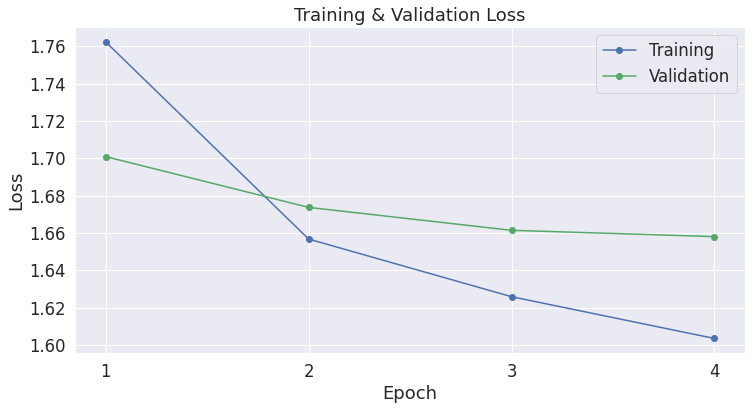

In [51]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Testing

In [52]:
net.eval()

predictions , true_labels = [], []

print()
print('Testing...')

for (step, batch) in enumerate(testing_dataloader):

    batch = tuple(t.to(device) for t in batch)

    if len(batch[0]) != batch_size:
            continue
    
    if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(testing_dataloader)))

    b_input_ids, b_attention_mask, b_labels = batch

    with torch.no_grad():
        result = net(b_input_ids, attention_mask=b_attention_mask)

    label_ids = b_labels.to('cpu').numpy()

    _, predicted = torch.max(result.data, 1)

    predictions.append(predicted)
    true_labels.append(label_ids)

    del b_input_ids
    del b_attention_mask
    del b_labels
    torch.cuda.empty_cache()

print('DONE.')


Testing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  Batch    40  of    157.
  Batch    80  of    157.
  Batch   120  of    157.
DONE.


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

predicted_labels = np.concatenate([np.array(prediction.to('cpu'), dtype='long') for prediction in predictions])

y_true = np.concatenate(true_labels).flatten()
y_pred = predicted_labels.flatten()

print("Precision: {0:.4f}".format(precision_score(y_true, y_pred, average='macro'))) # unweighted average of precisions
print("Recall: {0:.4f}".format(recall_score(y_true, y_pred, average='macro'))) # unweighted average of recalls
print("F1-score: {0:.4f}".format(f1_score(y_true, y_pred, average='macro'))) # unweighted average of f1-scores

# Save model

In [ ]:
OUTPUT_DIR = os.path.join(PATH_TO_DISK, 'My Drive')
MODEL_NAME_TO_SAVE = 'sbert-original'
PARAMETERS_NAME_TO_SAVE = 'args-sbert-original.bin'

In [ ]:
output_dir = './model_save'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save model, tokenizer and training arguments
torch.save(net.state_dict(), os.path.join(output_dir, MODEL_NAME_TO_SAVE))
sbertTokenizer.save_pretrained(output_dir)
torch.save(trainingParameters, os.path.join(output_dir, PARAMETERS_NAME_TO_SAVE))

Look at the sizes, out of curiousity

In [53]:
!ls -l --block-size=K ./model_save/

total 1672268K
-rw-r--r-- 1 root root       1K May 29 12:17 args-sbert-original.bin
-rw-r--r-- 1 root root 1667820K May 29 12:17 sbert-original
-rw-r--r-- 1 root root       1K May 29 12:17 special_tokens_map.json
-rw-r--r-- 1 root root       1K May 29 12:17 tokenizer_config.json
-rw-r--r-- 1 root root    2689K May 29 12:17 tokenizer.json
-rw-r--r-- 1 root root    1739K May 29 12:17 vocab.txt


Save to Google Drive

In [ ]:
torch.save(net.state_dict(), os.path.join(OUTPUT_DIR, MODEL_NAME_TO_SAVE))
sbertTokenizer.save_pretrained(OUTPUT_DIR)
torch.save(trainingParameters, os.path.join(OUTPUT_DIR, PARAMETERS_NAME_TO_SAVE))

To load model from drive:

In [54]:
from transformers import BertTokenizerFast

# Net class must be the same as class of the saved model. Initialize it somewehere before
model = Net()

model.load_state_dict(torch.load(os.path.join(output_dir, MODEL_NAME_TO_SAVE)))
tokenizer = BertTokenizerFast.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

Net(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine

Done :)